In [2]:
# Import packages
# Make sure you have RiverREM imported, check readme for instructions
import os
import pathlib
import zipfile

import geopandas as gpd
import matplotlib.pyplot as plt
from load_plot_model import load_dtm, plot_model, plot_hists, run_rem_maker
from riverrem.REMMaker import REMMaker, clear_osm_cache
import requests
import rioxarray as rxr
from rioxarray.merge import merge_arrays

In [3]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'watershed-project')

# Try/Except Block   
try:
    os.chdir(working_dir)
except:
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    os.chdir(working_dir)
else:
    print('{} is now the working directory'.format(working_dir))

/Users/lchipman/earth-analytics/data/watershed-project is now the working directory


## Download and unzip lidar
ideally would download from CO hs site, but there is no direct link. I uploaded zip files to git, and had to change the file content names bc otherwise  running into issues unzipping - the extracted files include root directory in filename, and the name is not callable

In [4]:
# Function to create dictionary to store info for lidar download
def get_lidar_url(site_names):
    """
    Creates a dictionary to store info for lidar download
    
    Parameters
    -------------
    site_names: list
        List of the site names.
    
    Returns
    ------------
    site_names: list
        List of dictionaries with sitename, lidar url, and zip filename.
    
    """
    #lidar_url = ('https://github.com/lechipman/watershed-project/'
     #                'releases/download/v2.0.0/{}_lidar.zip'.format(site_name))
    site_lidar_urls = []
    for site_name in site_names:
        site_lidar_urls.append({
            'site_name': site_name,
            'lidar_url': ('https://github.com/lechipman/'
                          'watershed-project/releases/download/v2.0.0/'
                          '{}_lidar.zip'.format(site_name)),
                          'zip_filename': ('{}_lidar.zip'.format(site_name))
    })
    return site_lidar_urls

In [5]:
# Call the function to create dictionaries for the sites.
site_names = ['applevalley', 'hallmeadows', 'hallmeadows2', 'highway93']
site_lidar_urls = get_lidar_url(site_names=site_names)

In [14]:
# Save the lidar DTMs to the dictionaries
for site in site_lidar_urls:
    site['lidar_dtm'] = load_dtm(data_url=site['lidar_url'], 
                                     site_name=site['site_name'],
                                     file_name=site['zip_filename'])

In [18]:
# Merge the 2 hallmeadows tiles and replace dtm:
for site in site_lidar_urls:
    if site['site_name'] == 'hallmeadows':
        site['lidar_dtm'] = (merge_arrays(dataarrays = [site_lidar_urls[1]['lidar_dtm'], 
                                                        site_lidar_urls[2]['lidar_dtm']]))
    if site['site_name'] == 'hallmeadows2':
        site_lidar_urls.remove(site)

## Plot the LiDAR DTMs

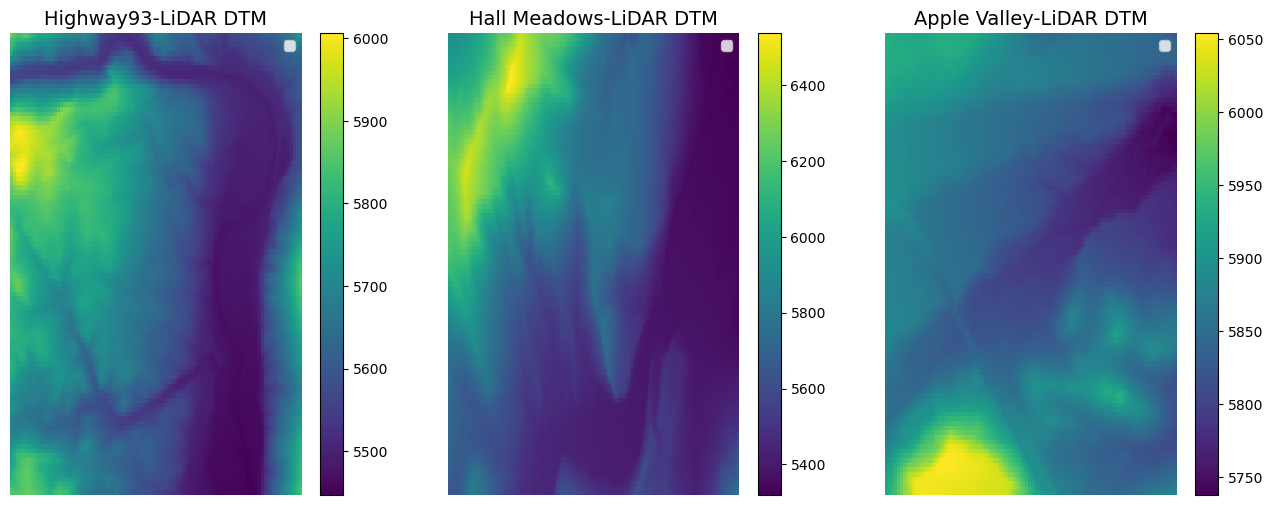

In [22]:
# Call function to plot Lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
#lidar_dtm_list = [applevalley_lidar_dtm, hallmeadows_lidar_dtm, highway93_lidar_dtm]
plot_title = ['Highway93-LiDAR DTM', 
              'Hall Meadows-LiDAR DTM',
              'Apple Valley-LiDAR DTM']

for i, axe in enumerate(axes.flatten()):
    plot_model(model=site_lidar_urls[i]['lidar_dtm'], 
               title=plot_title[i],
               coarsen=(True),
               xpix=20, 
               ypix=20,
               ax=axe)

## Clip the lidar DTMs

In [23]:
def boundary_gdf(data_url, site_name):
    "Downloads boundary shapefiles and open as a gdf"
    override_cache = False
    data_dir='shapefiles'
    data_path = os.path.join('shapefiles.zip')
    
    # Cache data file
    if (not os.path.exists(data_path)) or override_cache:
        print('{} does not exist. Downloading...'.format(data_path))
        # Download full data file as zipfile
        response = requests.get(data_url)

        # Write in respose content using context manager
        with open(data_path, 'wb') as data_file:
            data_file.write(response.content)
            
    with zipfile.ZipFile(data_path, 'r') as shape_zipfile:
        shape_zipfile.extractall(working_dir)
    data_path=os.path.join(data_dir,
                           '{}_bounding_polygon'.format(site_name),
                           'Bounding_Polygon.shp'.format(site_name))

    # Open the bounding polygon as gdf
    try:
        gdf = gpd.read_file(data_path)
        return gdf
    except:
        print('There is no bounding polygon for the {} site, ' 
              'skipping this site'.format(site_name))

In [24]:
# Call function to create bounding polygon gdf for each site, save to site_lidar_urls
shape_url = ('https://github.com/lechipman/watershed-project/'
                 'releases/download/v2.0.0/shapefiles.zip')

for site in site_lidar_urls:
    site['bounding_polygon'] = (boundary_gdf(
                                data_url=shape_url, 
                                site_name=site['site_name']))

In [26]:
# Write function for opening and clipping the geotiff file

def lidar_clip(lidar_dtm, clip_gdf):
    """
  Clips and reprojects the lidar raster to the area of interest (AOI)
  using a supplied shapefile.

  Parameters
  ----------
  lidar_dtm: dataarray
      The dtm to clip.
  clip_gdf: geodatafram
      GDF of the AOI.

  Returns
  -------
  clipped_dtm = DataArray
      The preprocessed raster dataset.
  """
    #data_dir = os.path.join(site_name, '{}_lidar'.format(site_name))
    reproject_dtm = lidar_dtm.rio.reproject("EPSG:4326")
    clipped_dtm = (reproject_dtm
                  .squeeze()
                  .rio.clip(clip_gdf.geometry, crs=clip_gdf.crs))
    # Save the clipped lidar dtm as raster for use in RiverREM
    # clipped_dtm.rio.to_raster(data_dir, '{}_lidar_dtm_clipped.tif'.format(site_name))
    
    return clipped_dtm

In [27]:
# Clip the lidar dtm to bounding polygon and add to dictionary
for site in site_lidar_urls:
    site['lidar_clipped_dtm'] = lidar_clip(lidar_dtm = site['lidar_dtm'],
                                           clip_gdf = site['bounding_polygon'])

In [34]:
# put this into clip function - set path
site_lidar_urls[0]['lidar_clipped_dtm'].rio.to_raster('lidar_dtm_clipped.tif')

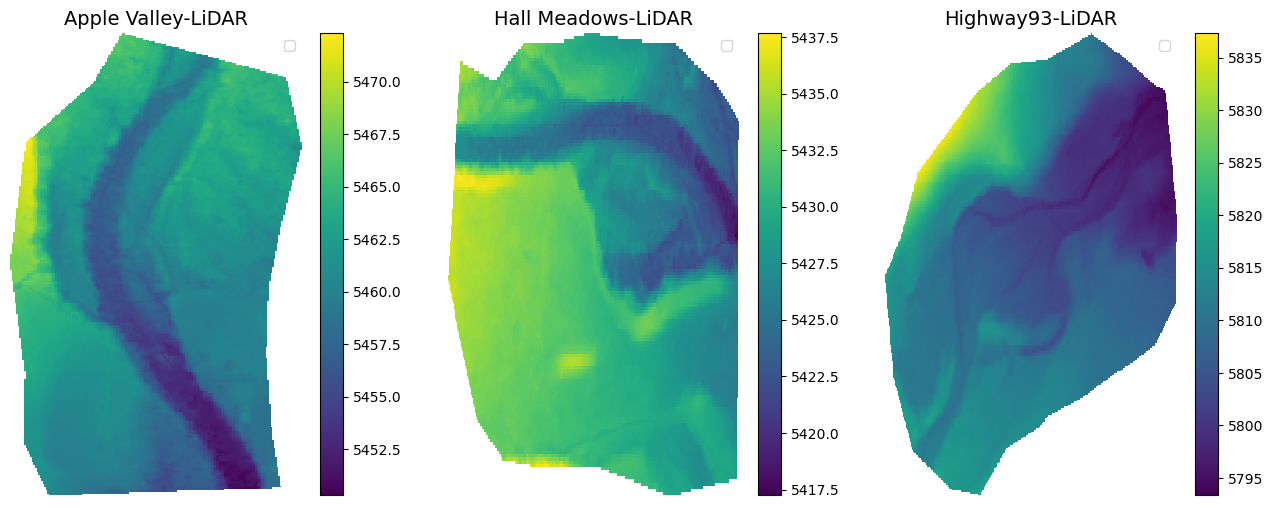

In [31]:
# Call function to plot lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
plot_title = ['Apple Valley-LiDAR', 
              'Hall Meadows-LiDAR',
              'Highway93-LiDAR']
for i, axe in enumerate(axes.flatten()):
    plot_model(model=site_lidar_urls[i]['lidar_clipped_dtm'], 
               title=plot_title[i],
               coarsen=(False),
               ax=axe)

# Load the UAV DTMs and REMs

In [ ]:
# Define urls to UAV DTMs and REMs (saved on zenodo)
# make into function
highway93_dtm_url = ('https://zenodo.org/record/8218054/files/'
                     'highway93_uav_dtm.tif?download=1')
highway93_rem_url = ('https://zenodo.org/record/8218054/files/'
                     'highway93_uav_rem.tif?download=1')
applevalley_dtm_url = ('https://zenodo.org/record/8218054/files/'
                       'applevalley_uav_dtm.tif?download=1')
applevalley_rem_url = ('https://zenodo.org/record/8218054/files/'
                       'applevalley_uav_rem.tif?download=1')
hallmeadows_dtm_url = ('https://zenodo.org/record/8218054/files/'
                       'hallmeadows_uav_dtm.tif?download=1')
hallmeadows_rem_url = ('https://zenodo.org/record/8218054/files/'
                       'hallmeadows_uav_rem.tif?download=1')

In [ ]:
# Load dataarrays for UAV-derived dtms and rems and lidar rems
highway93_uav_dtm = load_dtm(data_url = highway93_dtm_url, 
                          site_name = 'highway93',
                          file_name = 'highway93_dtm.tif')
applevalley_uav_dtm = load_dtm(data_url = applevalley_dtm_url, 
                          site_name = 'applevalley',
                          file_name = 'applevalley_dtm.tif')
hallmeadows_uav_dtm = load_dtm(data_url = hallmeadows_dtm_url, 
                          site_name = 'hallmeadows',
                          file_name = 'hallmeadows_dtm.tif')
highway93_uav_rem = load_dtm(data_url = highway93_rem_url, 
                          site_name = 'highway93',
                          file_name = 'highway93_rem.tif')
applevalley_uav_rem = load_dtm(data_url = applevalley_rem_url, 
                          site_name = 'applevalley',
                          file_name = 'applevalley_rem.tif')
hallmeadows_uav_rem = load_dtm(data_url = hallmeadows_rem_url, 
                          site_name = 'hallmeadows',
                          file_name = 'hallmeadows_rem.tif')

## To do for steps above
1) how to write to raster - running into error driver no found
2) speeding up plots/reducing file size? - pickling??

## LiDAR and UAV DTM histograms

In [ ]:
all_dtm_list = (highway93_uav_dtm, applevalley_uav_dtm,
                highway93_clip_dtm, applevalley_clip_dtm)
# Call function to plot histogram of UAV REMs
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
plot_title = ['Highway93-UAV', 
              'Apple Valley-UAV', 
              'Highway93-LiDAR', 
              'Apple Valley-LiDAR']

for i, axe in enumerate(axes.flatten()):
    plot_hists(model=all_dtm_list[i], 
               titles=plot_title[i],
               main_title='UAV and LiDAR DTM Histograms',
               color=('cyan'),
               fig=fig,
               ax=axe)

In [ ]:
# Run the process lidar function to create a lidar-derived DTM for each site
site_names = ('highway93', 'applevalley', 'hallmeadows')

# try using locals
#lidar_dtm_list = []
#for site in site_names:
 #   processed_lidar_dtm = reproject_match_lidar(site_uav_rem, lidar_path, lidar_crs, name)
    #lidar_dtm_list.append(lidar_rem)
    

# Create LiDAR REMs Using REMMaker Tool

In [ ]:
def run_rem_maker(name, k=100):
    """Run the REMMaker tool"""
    
    # Input the DTM file path and desired output directory
    override_cache = False
    lidar_dtm_path = os.path.join(('LiDAR_DTM_{}.tif').format(name))
    lidar_out_path = os.path.join(lidar_dir, ('lidar_{}').format(name))
    lidar_rem_path = os.path.join(lidar_out_path, 
                                  ('LiDAR_DTM_{}_REM.tif').format(name))

    # Run the REMMaker if the path to the REM does not already exist
    if (not os.path.exists(lidar_rem_path)) or override_cache:
        rem_maker = REMMaker(dem=lidar_dtm_path, 
                             out_dir=lidar_out_path, 
                             interp_pts=1000, 
                             k=100)

        # clear OSM cache
        clear_osm_cache()

        # create an REM
        rem_maker.make_rem()

        # create an REM visualization with the given colormap
        rem_maker.make_rem_viz(cmap='mako_r')

    else:
        print('The REM already exists. Not running REMMaker')

In [ ]:
# Create REM for all sites with run_rem_maker function
site_names = ('highway93', 'applevalley', 'hallmeadows')
lidar_rem_list = []

for site in site_names:
    run_rem_maker(name=site)
    lidar_rem_path = os.path.join(lidar_dir,
                                  ('lidar_{}').format(site),
                                  ('LiDAR_DTM_{}_REM.tif').format(site))
    lidar_rem = rxr.open_rasterio(lidar_rem_path, masked=True)    
    lidar_rem_list.append(lidar_rem)

# Plot the UAV and LiDAR Derived REMs

In [ ]:
# Plot the REMs
# Define plot space with x subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

# List of site names to pass to function for titles
plot_title = ('UAV-Derived REM for Highway 93', 
              'UAV-Derived REM for Apple Valley', 
              'UAV-Derived REM for Hall Meadows',
              'LiDAR-Derived REM for Highway 93', 
              'LiDAR-Derived REM for Apple Valley', 
              'LiDAR-Derived REM for Hall Meadows')

# List of REMs to pass to plot function
all_rem_list = (uav_rem_list + lidar_rem_list)

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=all_rem_list[i],
        title=plot_title[i],
        coarsen=(True, True, True, False, False, False),
        ax=axe)
# Note - I increased value of k in the REMMAker and streaking improved!!
# "param k: number of nearest neighbors to use for IDW interpolation. If None, an appropriate value is estimated.
#  The estimation routine uses k between 5-100 points (0.5-10% of the river length) depending on the
#  sinuosity of the river of interest. Greater values of k are used for more sinuous rivers.""